In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower
import pandas as pd
import re

In [2]:
omega_nu = np.array([0.0006356, 0.002, 0.006356])
omega_index = 1 # while we debug, we confine our attention to just one value

In [3]:
# Keep in mind that this is NOT the same file as the original "cosmology_Aletheia.dat"
# that Ariel gave us! If you use the unaltered version, you will get a segfault
cosm = pd.read_csv("cosmologies.dat", sep='\s+')

# The following code is somewhat hard;
# I'm not sure how better to do it.
redshift_column = re.compile("z.+")

def parse_redshifts(model_num):
    z = []
    model = cosm.loc[model_num]
    
    for column in cosm.columns:
        if redshift_column.match(column):
            z.append(model[column])
            
    # No need to sort these because they should already
    # be in descending order.
    return np.array(z)

In [4]:
def kzps(mlc, omnuh2_in, massive_neutrinos=False, sigma12_in=1, zs = [0]):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model
    @param mlc : "MassLess Cosmology"
        a dictionary of values
        for CAMBparams fields
    @param omnuh2_in : neutrino physical mass density
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the desired sigma12 of the model
    @massive_neutrinos : if this is True,
        the value in omnuh2_in is used to set omnuh2.
        If this is False,
        the value in omnuh2_in is simply added to omch2.
    """ 
    pars = camb.CAMBparams()
    omch2_in = mlc["omch2"]
    mnu_in = 0
    if massive_neutrinos:
        # This is a horrible workaround, and I would like to get rid of it ASAP
        # The following line destroys dependence on TCMB and neutrino_hierarchy, possibly more
        mnu_in = omnuh2_in * camb.constants.neutrino_mass_fac / (camb.constants.default_nnu / 3) ** 0.75 
        omch2_in = mlc["omch2"] - omnuh2_in
    pars.set_cosmology(
        H0=mlc["h"] * 100,
        ombh2=mlc["ombh2"],
        omch2=omch2_in,
        omk=mlc["OmK"],
        mnu=mnu_in
    )
    pars.InitPower.set_params(As=mlc["A_s"], ns=mlc["n_s"])
    
    #pars.DarkEnergy = camb.dark_energy.DarkEnergyPPF(w=mlc["w0"], wa=float(mlc["wa"]))
    pars.set_dark_energy(w=mlc["w0"], wa=float(mlc["wa"]), dark_energy_model='ppf')
    
    # The following bogus line can expose whether the simulation is paying attention to DE
    # (for some reason, the pair (-100, -100) did not look strange at all!) 
    # pars.set_dark_energy(w=-0, wa=0, dark_energy_model='ppf') 
    
    # To change the the extent of the k-axis,
    # change the following line as well as the "get_matter_power_spectrum" call
    pars.set_matter_power(redshifts=zs, kmax=10.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    
    if sigma12_in != 1:
        sigma12_unmodified = results.get_sigmaR(12, hubble_units=False)
        As_rescaled = 2e-9 * (sigma12_in / sigma12_unmodified) ** 2

        pars.InitPower.set_params(As=As_rescaled, ns=mlc["n_s"])

    k, z, p = results.get_matter_power_spectrum(
        minkh=1e-4, maxkh=10.0, npoints = 200,
        var1=8, var2=8
    )
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    
    # The following line is helpful when debugging the mnu \ omnuh2 shenanigans
    #print("my nu density:", pars.omnuh2)
    
    return k, z, p, sigma12

In [5]:
# Let us begin our demonstration by considering only the
# middle of the
# given neutrino mass physical densities, omega_nu[omega_index]
k_massless_list = []
z_massless_list = []
p_massless_list = []
s12_massless_list = []

k_massive_list = []
z_massive_list = []
p_massive_list = []
s12_massive_list = []

for index, row in cosm.iterrows():
    if index > 7:
        continue # Don't know how to handle the last one yet
    
    z_in = parse_redshifts(index)
    
    k, z, p, s12 = kzps(row, omega_nu[omega_index], massive_neutrinos=False,
                       zs=z_in)
    k_massless_list.append(k)
    z_massless_list.append(z)
    p_massless_list.append(p)
    s12_massless_list.append(s12)
    
    k, z, p, s12 = kzps(row, omega_nu[omega_index], massive_neutrinos=True,
                       zs=z_in)
    k_massive_list.append(k)
    z_massive_list.append(z)
    p_massive_list.append(p)
    s12_massive_list.append(s12)

In [6]:
colors = ["green", "blue", "brown", "red", "black", "orange", "purple", "magenta"]
# Argh! We have duplicates!!
#styles = ["solid", "dotted", "dashed", "dashdot", "solid", "dotted", "dashed", "dashdot"]
styles = ["solid"] * 8

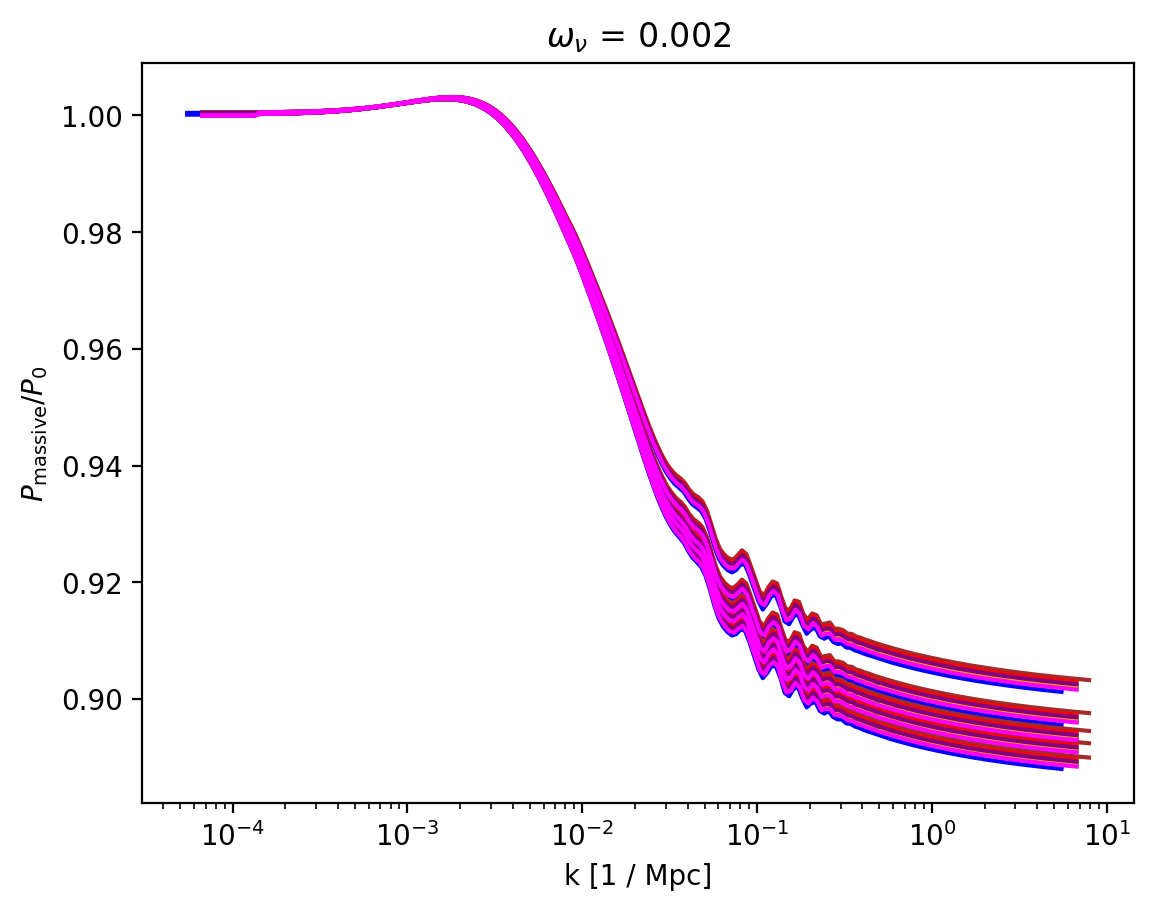

In [7]:
for i in range(len(k_massive_list)):
    h = cosm.loc[i]["h"]
    for j in range(5):
        plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i) + \
                 ", no renormalizing, z=" + str(parse_redshifts(index)[j]),
                c=colors[i], linestyle=styles[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]))
    #plt.legend()

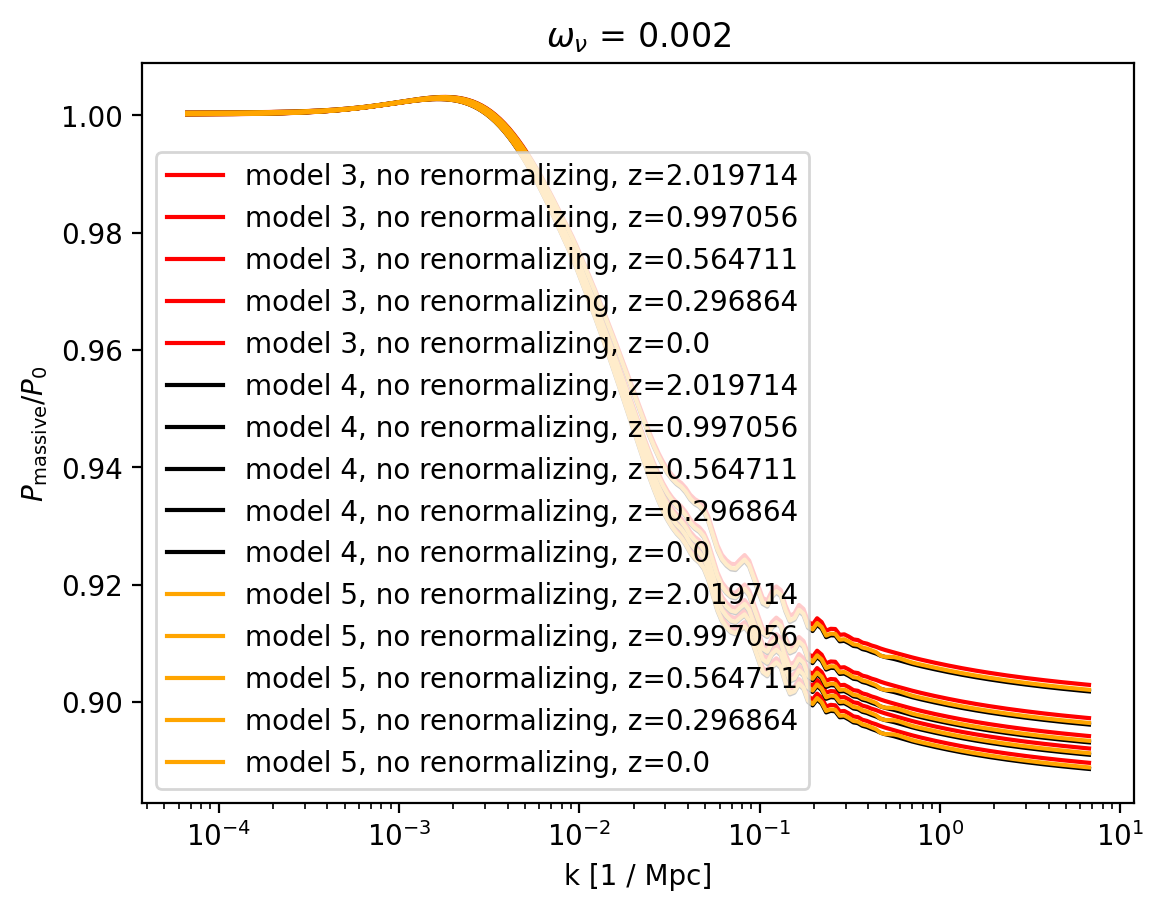

In [8]:
for i in range(3, 6):
    h = cosm.loc[i]["h"]
    for j in range(5):
        plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i) + \
                 ", no renormalizing, z=" + str(parse_redshifts(index)[j]),
                c=colors[i], linestyle=styles[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]))
    plt.legend()

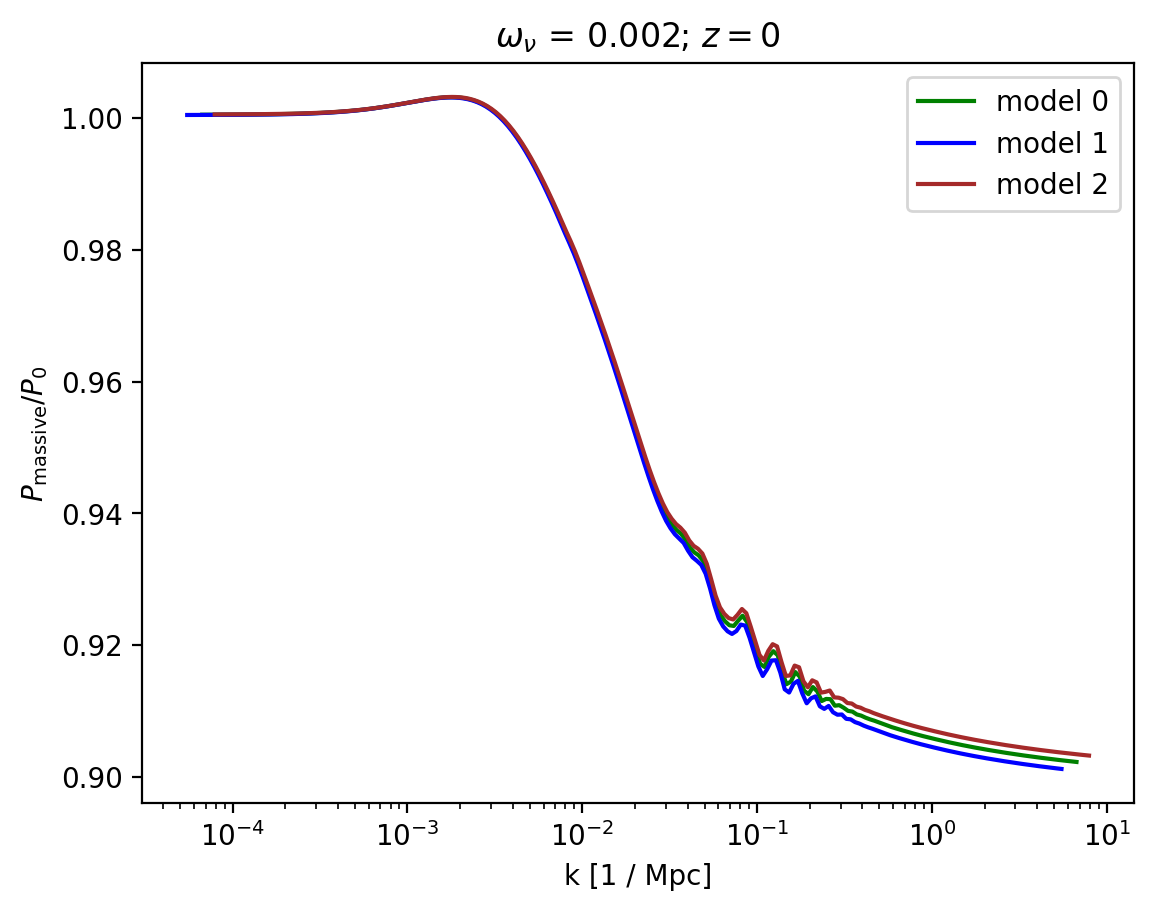

In [9]:
for i in range(0, 3):
    h = cosm.loc[i]["h"]
    j = 4 # just look at z=0 before moving on
    plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i), c=colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]) + "; $z=0$")
    plt.legend()

Problems? and problems:
* I am currently not re-normalizing the amplitude of one model based on its counterpart. At least, I *think* I'm not doing that.
* I need to set a k_min value so that the x axes align better

In [10]:
baseline = pd.read_csv("power_nu/Aletheia_powernu_zorig_nu0.002_caso0_0000.dat",
                       names=["k", "P_no", "P_nu", "ratio"], sep='\s+')
baseline_max = pd.read_csv("power_nu/Aletheia_powernu_zorig_nu0.002_caso0_0004.dat",
                       names=["k", "P_no", "P_nu", "ratio"], sep='\s+')

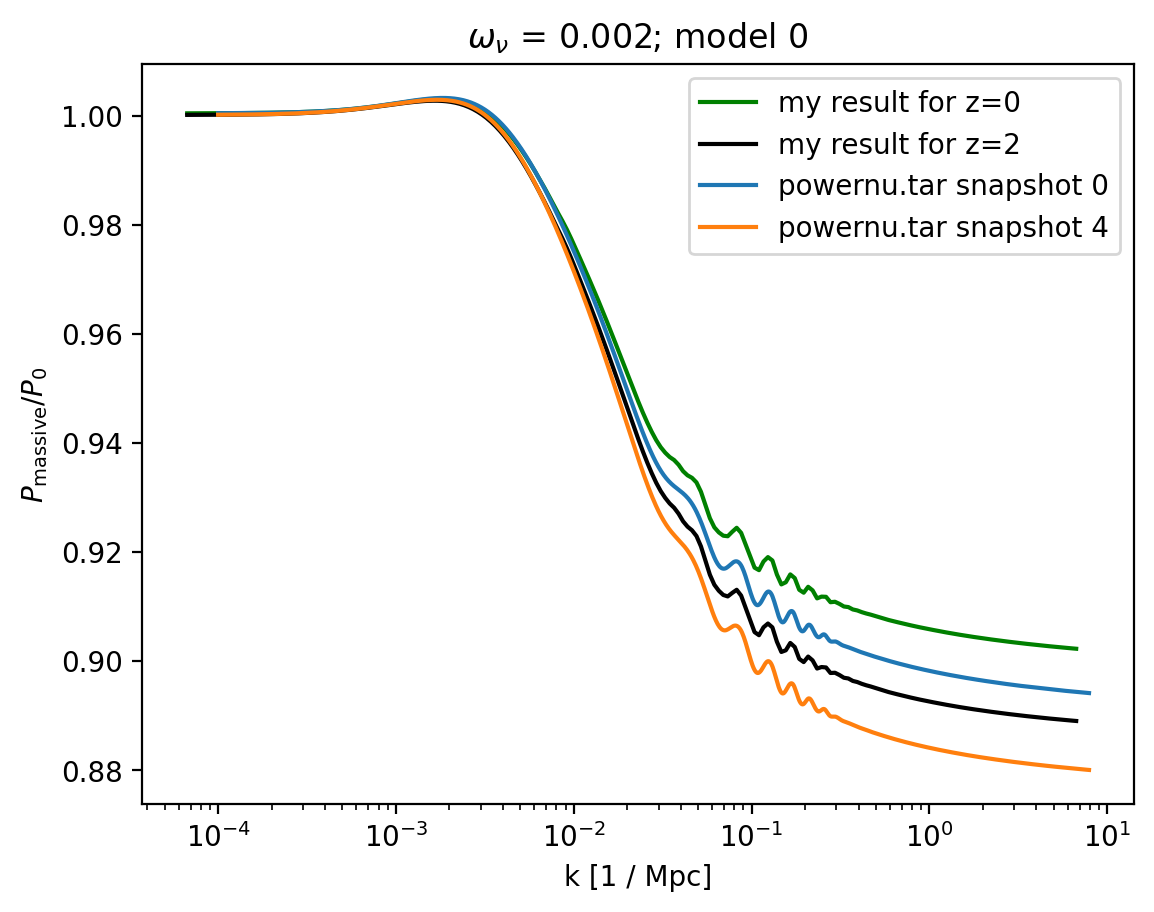

In [11]:
# Let's just look at model 0 for the initial comparisons
i = 0
# Let's just look at redshift 0 for the initial comparisons
""" but the question is... is this the same redshift
as the plot to which I am comparing? """
j = 4

h = cosm.loc[i]["h"]
plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
             label="my result for z=0", c=colors[i])
j = 0 # This will correspond to z=2 for the model0 case.
plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
             label="my result for z=2", c="black")
plt.plot(baseline["k"], baseline["ratio"], label="powernu.tar snapshot 0")
plt.plot(baseline_max["k"], baseline_max["ratio"], label="powernu.tar snapshot 4")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]) + "; model 0")
plt.legend()

Unfortunately, before we can dunk on my plots, we need to make absolutely certain that we are comparing like to like (the redshifts need to be the same)

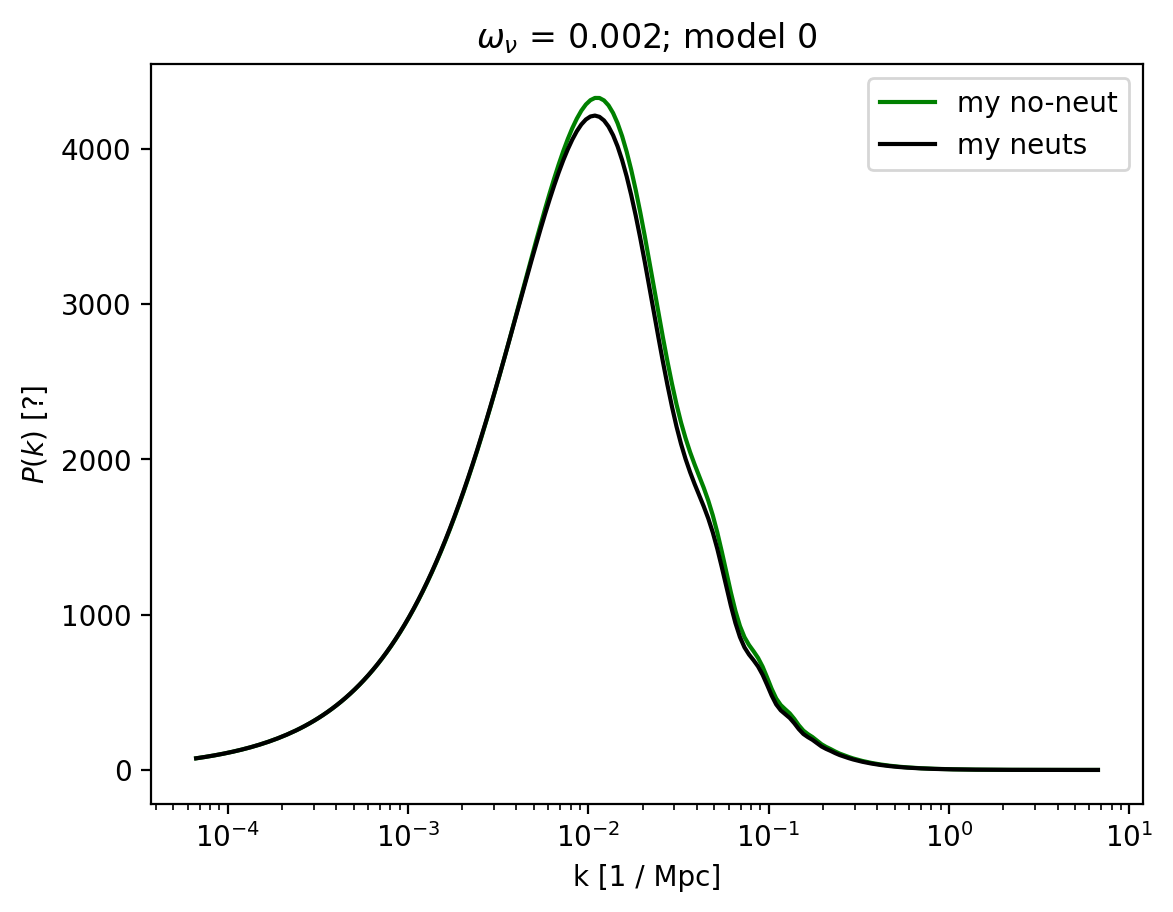

In [12]:
h = cosm.loc[i]["h"]
j = 4
plt.plot(k_massless_list[i] * h, p_massless_list[i][j],
             label="my no-neut", c=colors[i])
plt.plot(k_massless_list[i] * h, p_massive_list[i][j],
             label="my neuts", c="black")
#plt.plot(baseline["k"], baseline["P_no"], label="powernu.tar no-neut")
#plt.plot(baseline["k"], baseline["P_nu"], label="powernu.tar neuts")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P(k)$ [?]")
plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]) + "; model 0")
plt.legend()